### TPC2 MCE 2023-24

É dia de festa! E o prato principal é leitão assado no forno. Mas a vida está cara, conseguimos comprar o leitão a um preço mais em conta no produtor(pessoa de confiança!) e vamos assar no forno lá em casa. O problema é que nunca fizemos isto, e se der asneira a despesa é grande e a festa fica um pouco estragada (embora a companhia seja o mais importante, não é?)! Por isso procuramos instruções na Web. E encontramos no site https://www.seriouseats.com/whole-roasted-suckling-pig-recipe algumas indicações. Parece que o importante é alcançar a temperatura certa no sítio certo, de modo a estar perfeitamente cozinhado. Assim, queremos começar com o forno a $150^{o}C$ e deverá estar pronto quando a temperatura no ombro (bem fundo) atinja $70^{o}C$. Depois tostar a pele deve ser fácil.

Mas um físico testa primeiro! E aqui, não havendo leitões baratos para testar, simulamos! Temos um forno de $60$cm de altura por $60$cm de largura, e para não demorar a simulação mais do que a assadura, supomos que é uma boa aproximação reduzir o problema a 2D. O nosso leitão tem cerca de $45cm$ de comprimento, pelo que cabe no forno. Este tem duas resistências, uma em cima, outra em baixo, que alcançam temperaturas elevadas. Para simplificar, vamos supor que podemos considerar que a temperatura do ar dentro do forno é sempre a determinada pelo que indica o mostrador cá fora.

O leitão é colocado no forno apenas quando o termóstato desliga ao atingir a temperatura pré-definida (os $150^{o}C$). E somos lestos, logo não há tempo para descer a temperatura. Daí em diante qualquer variação da temperatura é rapidamente contrariada pelo termóstato, que liga as resistências e repõe a temperatura. Assim, podemos supor que a temperatura do ar dentro do forno é sempre $150^{o}C$.

Inserimos um termómetro de cozinha bem fundo no ombro do leitão, que é o sítio mais difícil de aquecer. O termómetro envia por WiFi a leitura para o telemóvel (é, também não sabia que havia disto!), de modo a  não termos que abrir o forno e perturbar a temperatura. No instante $t=0$ o leitão, que veio do frigorífico onde esteve a marinar toda a noite, tem uma temperatura de $6^{o}C$.

A constante de difusão média da carne do leitão é $\alpha = 1.45\times 10^{-7} m^2/s$ (como sabemos ${\displaystyle \alpha ={\frac {k}{\rho c_{p}}}}$
onde $k$ é a condutividade térmica ($W/(m·K)$), $c_p$ é a capacidade calorífica específica ($J/(kg·K)$), e $\rho$ é a densidade ($kg/m^3$)).

Não se esqueça das unidades correctas para exprimir a temperatura.

Tem anexa uma silhueta do leitão para usar na simulação. Com esta pode criar uma máscara (0/1 ou /False/True) para os pontos onde há variação de temperatura (no leitão) versus aqueles onde a temperatura é constante (ar dentro do forno). Por exemplo, depois de importar a imagem para um array chamado _img_, faz _leitao_bool = img<0.8_. Onde este array dá falso, queremos que a temperatura seja constante. (Nota1: o conceito de máscara pode ser confuso: onde a condição dá verdadeiro a máscara tem falso, que quer dizer aqui não se mexe; é como se fosse o negativo; Nota2: não especifiquei exactamente o local onde deve ser lida a temperatura com o termómetro, para avaliar o estado de assadura; como é evidente esse ponto deve ser na parte mais interna do leitão! Podem ignorar esse ponto e considerar que está assado quando a temperatura mínima dentro do leitão atingir os $70^{o}C$).

In [72]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from PIL import Image
from typing import Callable

a) Defina o seu domínio de simulação, indicando as suas dimensões, a sua grelha, as condições fronteira, e as condições iniciais, e tudo o mais necessário para definir bem o problema.
Importe a imagem fornecida e crie uma máscara para usar posteriormente. Só precisamos de uma imagem em cinzento de modo a distinguir o que é leitão do que não é. E note que o leitão enche esta imagem, mas não deve encher o domínio (são indicadas dimensões no enunciado acima).

Vamos indicar os parâmetros do problema em unidades SI, uma vez que todos valores são de uma ordem grandeza suficientemente próxima de $1$ para não ser necessário adimensionalizar o problema.

In [73]:
# Parâmetros do Problema (Unidades SI)

# Dimensões e Temperatura do Forno
FORNOX = 0.60
FORNOY = 0.60
FORNOT = 150 + 273.15

# Dimensões e Temperatura do Leitão
LEITAOX = 0.45
LEITAOTI = 6 + 273.15
LEITAOTF = 70 + 273.15

# Coeficiente de difusão
DIF = 1.45e-7


# Parâmetros da Simulação

# Número de pontos a usar
NX = 1001
NY = 1001

# Espaçamento entre pontos da grelha
DX = FORNOX / (NX-1)
DY = FORNOY / (NY-1)

Podemos então importar a imagem e criar um array onde irá estar guardada a temperatura em cada ponto, bem como a máscara que indica que pontos podem evoluir no tempo.

750 417


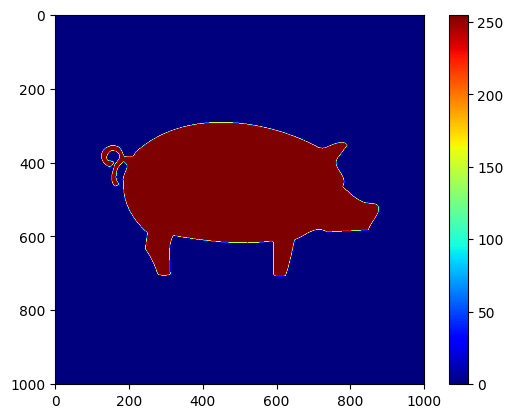

In [74]:
# Importar a imagem
leitao = Image.open("leitao_bw.png")

# Tamanho da imagem
XMAX, YMAX = leitao.size
LEITAOY = LEITAOX * (YMAX / XMAX)

# Espaçamento entre pontos da grelha da imagem do leitão
NXLEITAO = int(LEITAOX / FORNOX * NX)
NYLEITAO = int(LEITAOY / FORNOY * NY)

DXLEITAO = LEITAOX / (NXLEITAO - 1)
DYLEITAO = LEITAOY / (NYLEITAO - 1)

print(NXLEITAO, NYLEITAO)

# Transformar em array
ll = np.array(leitao)

# Posicionamos o leitão de forma a que fique no centro do forno
XI = (NX - NXLEITAO) // 2
YI = (NY - NYLEITAO) // 2


# Interpolar a imagem png para obter a resolução desejada
xx = np.arange(XMAX)
yy = np.arange(YMAX)
coords = []

MULTX = DXLEITAO * NXLEITAO / XMAX
MULTY = DYLEITAO * NYLEITAO / YMAX
for i in range(XMAX):
    for j in range(YMAX):
        coords += [(XI * DX + i * MULTX, YI * DY + j * MULTY)]

interpol = sp.interpolate.LinearNDInterpolator(coords, ll.flatten(order="F"), fill_value=0)

# Colocar o leitão dentro do forno e definir a grelha
xx = np.linspace(0, FORNOX, NX)
yy = np.linspace(0, FORNOY, NY)
mx, my = np.meshgrid(xx, yy)
ll = interpol(mx, my)

# Ver a imagem
plt.imshow(ll, cmap="jet")
plt.colorbar()
plt.show()

b) Escolha um dos métodos **estáveis** que aprendemos na UC. Determine as condições de estabilidade neste caso. Tendo em conta a grelha que escolheu em a), qual espera que seja o passo temporal máximo que pode usar?

Implemente o código necessário para resolver o nosso problema (na verdade já deve ter um código que faz isto dos exercícios da PL, dependendo do método que escolher).

c) Faça a simulação do problema usando o código que escreveu. Daí responda à questão: quanto tempo demorará a assar o leitão?

Compare a temperatura média em todo o leitão com a sua temperatura mínima, em cada instante da sua simulação. Produza um gráfico em função do tempo dessas duas quantidades.

d) Indique alguns modos como poderia melhorar a modelização do problema, para além de fazer o problema em 3D.